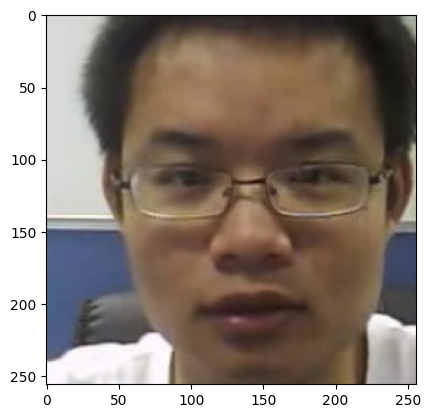

In [15]:
import cv2
from plot import imshow as show

image = cv2.imread(r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Real\14_1.avi_125_real.jpg")
show(image)

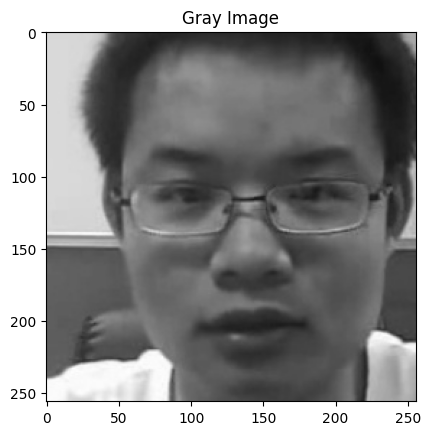

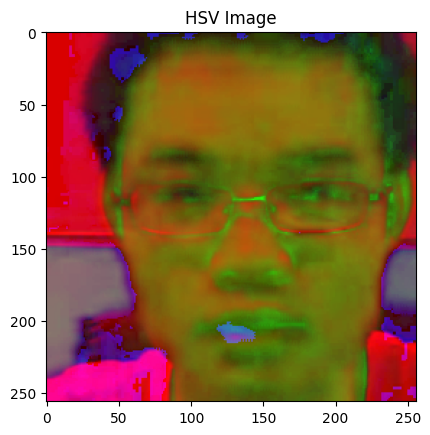

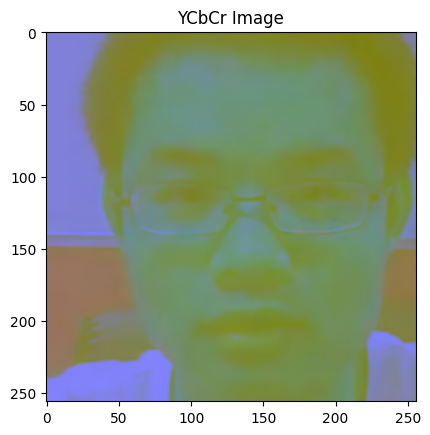

In [16]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
ycbcr_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

show(gray_img, "Gray Image")
show(hsv_img, "HSV Image")
show(ycbcr_img, "YCbCr Image")

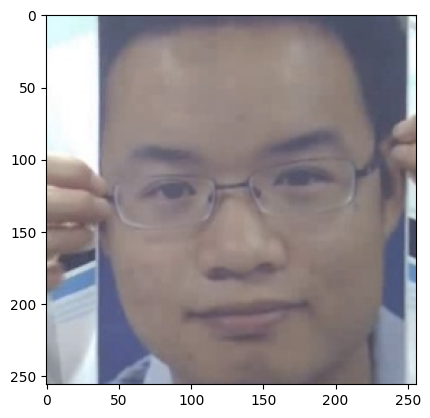

In [17]:
fake_image = cv2.imread(r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Fake\14_4.avi_50_fake.jpg")
show(fake_image)

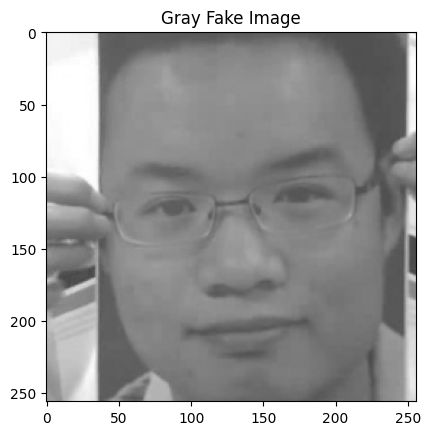

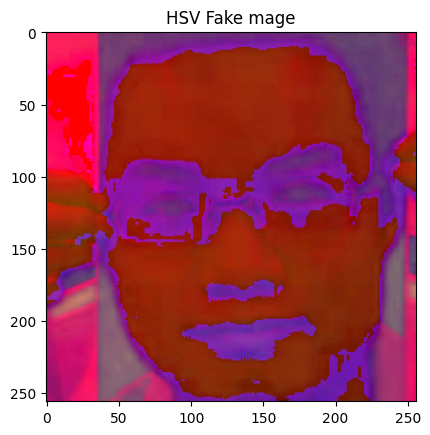

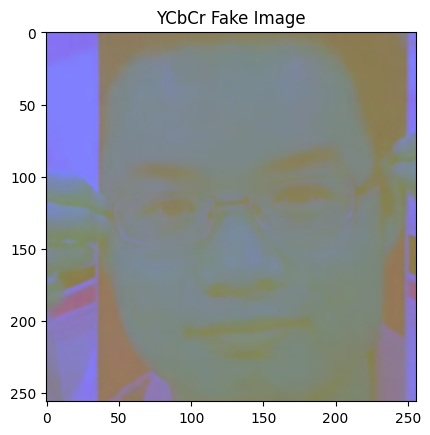

In [18]:
gray_fake_img = cv2.cvtColor(fake_image, cv2.COLOR_BGR2GRAY)
hsv_fake_img = cv2.cvtColor(fake_image, cv2.COLOR_BGR2HSV)
ycbcr_fake_img = cv2.cvtColor(fake_image, cv2.COLOR_BGR2YCrCb)

show(gray_fake_img, "Gray Fake Image")
show(hsv_fake_img, "HSV Fake mage")
show(ycbcr_fake_img, "YCbCr Fake Image")

In [19]:
from matplotlib import pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import os

radius = 1
n_points = 8 * radius

def extract_lbp_features(image):
    image = cv2.resize(image, (128, 128))
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    features = []
    
    for color_space in [rgb, hsv, ycbcr]:
        channels = cv2.split(color_space)
        for channel in channels:
            lbp = local_binary_pattern(channel, n_points, radius, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins = np.arange(0, n_points+3), density=True)
            features.extend(hist)

    return np.array(features)

def plot_concat_hist(hist, title):
    plt.figure(figsize=(10, 4))
    plt.plot(hist, color="blue")
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Frequency")
    plt.show()

def load_dataset(real_dir, fake_dir):
    X, y = [], []
    
    for img_name in os.listdir(real_dir):
        img_path = os.path.join(real_dir, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            features = extract_lbp_features(image)
            X.append(features)
            y.append(1)
            if img_name == "1_1.avi_25_real.jpg":
                plot_concat_hist(features, "LBP Histogram (Real Face)")
    
    for img_name in os.listdir(fake_dir):
        img_path = os.path.join(fake_dir, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            features = extract_lbp_features(image)
            X.append(features)
            y.append(0)
            if img_name == "1_3.avi_25_fake.jpg":
                plot_concat_hist(features, "LBP Histogram (Fake Face)")
            
    return np.array(X), np.array(y)

real_face_dir = r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Real"
fake_face_dir = r"C:\Users\Ruchir\OneDrive\Desktop\DOG\Fake"

X, y = load_dataset(real_face_dir, fake_face_dir)

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification report\n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Classification report
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2490
           1       0.95      0.88      0.92      2212

    accuracy                           0.92      4702
   macro avg       0.93      0.92      0.92      4702
weighted avg       0.93      0.92      0.92      4702

Confusion Matrix: 
 [[2392   98]
 [ 262 1950]]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
class ANNModel(nn.Module):
    
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = F.relu(self.fc4(F.relu(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x))))))))
        
        return self.fc5(x)

In [ ]:
def calculate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for feature, label in test_loader:
            output = model(feature)
            predicted = torch.argmax(output, dim=1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    
    accuracy = 100 * correct/total
    return accuracy

In [ ]:
model = ANNModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 50

loss_epoch = []
accuracy_epoch = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    accuracy = calculate_accuracy(model, test_loader) 
    accuracy_epoch.append(accuracy)   
    loss_epoch.append(total_loss)
    print(f"Epoch: {epoch}, Loss: {total_loss}, Test Accuracy: {accuracy}")

Epoch: 0, Loss: 159.88261005282402, Test Accuracy: 85.62313908974905
Epoch: 1, Loss: 110.67389857769012, Test Accuracy: 85.8570820927265
Epoch: 2, Loss: 103.97407804429531, Test Accuracy: 88.64313058273075
Epoch: 3, Loss: 91.07603202015162, Test Accuracy: 90.28073160357295
Epoch: 4, Loss: 84.24414252862334, Test Accuracy: 91.02509570395577
Epoch: 5, Loss: 77.54760428890586, Test Accuracy: 92.55635899617184
Epoch: 6, Loss: 72.56833186373115, Test Accuracy: 93.00297745640154
Epoch: 7, Loss: 65.890380281955, Test Accuracy: 92.87537218205019
Epoch: 8, Loss: 67.31338896416128, Test Accuracy: 93.47086346235645
Epoch: 9, Loss: 61.46998091973364, Test Accuracy: 93.53466609953212
Epoch: 10, Loss: 61.02355705201626, Test Accuracy: 93.85367928541046
Epoch: 11, Loss: 55.153819827362895, Test Accuracy: 93.96001701403658
Epoch: 12, Loss: 55.11517186649144, Test Accuracy: 93.93874946831136
Epoch: 13, Loss: 50.81561502441764, Test Accuracy: 94.8107188430455
Epoch: 14, Loss: 52.01859017647803, Test Acc

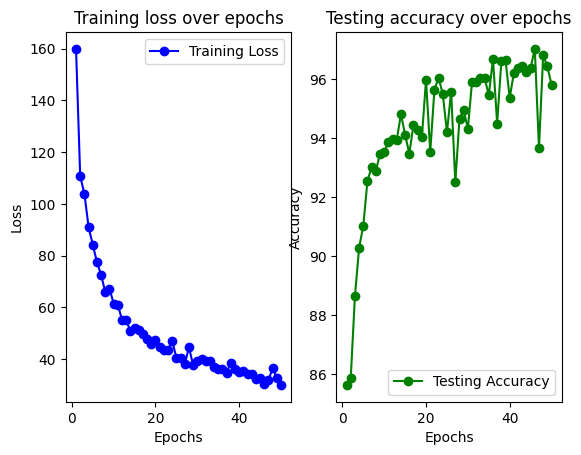

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_epoch, marker='o', color='blue', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss over epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), accuracy_epoch, marker='o', color='green', label='Testing Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing accuracy over epochs")
plt.legend()

plt.show()